<a href="https://colab.research.google.com/github/Maneekul/Image2/blob/main/Project_Image_2566.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fingerprint_enhancer


  Preparing metadata (setup.py) ... done
  Created wheel for fingerprint_enhancer: filename=fingerprint_enhancer-0.0.13-py3-none-any.whl size=8908 sha256=6732f3c70cc1a22578cd7b9980152c63adf78b99a169b12a1a997bc8afc83250
  Stored in directory: /root/.cache/pip/wheels/91/ae/50/978165dd230375061475f4594febfe8a42869c4cc5374f9740
Successfully built fingerprint_enhancer


In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import skimage.morphology as skmorph
from  skimage.measure import regionprops
from skimage.exposure import match_histograms
from skimage.util import random_noise
from glob import glob
from skimage.segmentation import slic
from skimage.future import graph
from skimage import color
from skimage.exposure import match_histograms
import fingerprint_enhancer
import pywt


from skimage.feature import local_binary_pattern

In [ ]:
def CCselectloop(label_img):
    min_size = int((label_img.shape[0]*label_img.shape[1])*0.0007) #0.00001

    labels , counts = np.unique(label_img,return_counts=True)

    output_img = label_img.copy()

    for y in range(label_img.shape[0]):
        for x in range(label_img.shape[1]):
            if counts[label_img[y,x]] >= min_size and label_img[y,x] != 0:
                output_img[y,x] = 1
            else:
                output_img[y,x] = 0
    return output_img

In [ ]:
import cv2
import numpy as np
from glob import glob
from skimage.feature import local_binary_pattern
from skimage import io
import matplotlib.pyplot as plt

MY_BI_DIR = "/content/drive/MyDrive/P3 FingerPhoto_Resolution/fingerphoto/"
MY_BI_groundtruth_DIR = "/content/drive/MyDrive/P3 FingerPhoto_Resolution/segment/"

exclude_files = ["5_3_1_16_1.jpg", "5_4_2_16_1.jpg"]

Myfiles0 = sorted(glob(MY_BI_groundtruth_DIR + "*.jpg"))
Myfiles = sorted(glob(MY_BI_DIR + "*.jpg"))

X = []

for orig_file, gt_file in zip(Myfiles, Myfiles0):
    if orig_file.split("/")[-1] in exclude_files:
        continue


    input_img = cv2.imread(orig_file)
    input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)

    input_BI_img = cv2.imread(gt_file)


    lower_gray = np.array([100, 100, 100], dtype="uint8")
    upper_gray = np.array([200, 200, 200], dtype="uint8")

    gray_mask = cv2.inRange(input_BI_img, lower_gray, upper_gray)
    gray_region = cv2.bitwise_and(input_img, input_img, mask=gray_mask)

    x1, y1, x2, y2 = 0, 0, 0, 0
    contours, _ = cv2.findContours(gray_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        x, y, w, h = cv2.boundingRect(contours[0])
        x1, y1, x2, y2 = x, y, x + w, y + h

    if x1 != x2 and y1 != y2:
        cropped_region = input_img[y1:y2, x1:x2]


    kernel_size = (17, 17)
    preprocessed_image0 = cv2.GaussianBlur(cropped_region, kernel_size, 0)

    clip_limit = 16 #8
    grid_shape = (30,30)
    CLAHE = cv2.createCLAHE(clipLimit=clip_limit,tileGridSize=grid_shape)
    My_output_CLAHE0 = CLAHE.apply(preprocessed_image0)
    output_img0 = fingerprint_enhancer.enhance_Fingerprint(My_output_CLAHE0)

    _, label_img = cv2.connectedComponents(output_img0)
    connected_components = CCselectloop(label_img)


    lbp_histograms = []
    if x1 != x2 and y1 != y2:
        cropped_region = input_img[y1:y2, x1:x2]

        # Iterate through different P and R values
        for p in range(4, 8):
            for r in range(3,21):
                label_img = local_binary_pattern(cropped_region, p, r)
                n_bins = int(label_img.max() + 1)
                lpb_hist, _ = np.histogram(label_img.flatten(), bins=n_bins, density=True)

                lbp_histograms.append(lpb_hist)
        X.append(np.concatenate(lbp_histograms))

    print(X)
    #plt.imshow(connected_components, cmap='gray')
    #plt.show()

print(X)


Streaming output truncated to the last 5000 lines.
       0.065303  ]), array([0.07773424, 0.05730068, 0.03313379, ..., 0.01899877, 0.00847437,
       0.07579967]), array([0.09252453, 0.05501835, 0.03968874, ..., 0.01873836, 0.00996214,
       0.08589435]), array([0.18364882, 0.05015484, 0.04933031, ..., 0.01825718, 0.01402711,
       0.12280758]), array([0.08093148, 0.06164762, 0.03302713, ..., 0.01440217, 0.00784824,
       0.06432134]), array([0.07822081, 0.05874551, 0.03493284, ..., 0.01582166, 0.00901547,
       0.07265074]), array([0.09252453, 0.05501835, 0.03968874, ..., 0.01873836, 0.00996214,
       0.08589435]), array([0.18117341, 0.05013346, 0.04812734, ..., 0.01914962, 0.01358091,
       0.11791144]), array([0.08093148, 0.06164762, 0.03302713, ..., 0.01440217, 0.00784824,
       0.06432134]), array([0.07822081, 0.05874551, 0.03493284, ..., 0.01582166, 0.00901547,
       0.07265074]), array([0.0840514 , 0.05318838, 0.04151735, ..., 0.01727257, 0.00955518,
       0.08948087])

In [ ]:
def findClassMean(class_dict):
  class_mean_dict = class_dict.copy()
  for class_i in class_dict:
    class_mean_dict[class_i] = np.mean(class_dict[class_i], axis=0)
  return class_mean_dict

def findOverallMean(class_dict, FEATURE_NUM):
  # -> Initial Dummy first row
  #overall_mean = 0
  all_records = np.zeros((1, FEATURE_NUM))

  # -> Merge All records of all class together
  for class_i in class_dict:
    class_records = class_dict[class_i]
    all_records = np.concatenate((all_records,class_records),axis=0)

  # -> Trim first row (Dummy) out
  all_records = all_records[1:, :]
  # -> Find Global mean of each Features
  overall_mean = np.mean(all_records, axis=0)
  return overall_mean

def S_withinClass(class_dict, FEATURE_NUM):
  print("--------------------------------------------------------1")
  # -> Find Mean of each Features / each Classes
  class_mean_dict = findClassMean(class_dict)
  S_w = np.zeros((FEATURE_NUM, FEATURE_NUM))
  print("--------------------------------------------------------2")
  for class_i in class_dict:
    # -> Class_i Matrix
    class_matrix = np.zeros((FEATURE_NUM, FEATURE_NUM))
    # -> Travelling to every records of each Class_i
    records = class_dict[class_i]
    means = class_mean_dict[class_i]
    print("--------------------------------------------------------3")
    for i in range(records.shape[0]):
      # -> Reshape for DOT product

      r = np.reshape(records[i,:], (FEATURE_NUM, 1))
      m = np.reshape(means, (FEATURE_NUM, 1))
      print("--------------------------------------------------------4")
      class_matrix += (r - m).dot((r - m).T)
    S_w += class_matrix
  return S_w

def S_betweenClass(class_dict, FEATURE_NUM):
  # -> Find Overall Mean
  overall_mean = findOverallMean(class_dict, FEATURE_NUM)
  # -> Find Class Mean
  class_mean_dict = findClassMean(class_dict)
  S_b = np.zeros((FEATURE_NUM, FEATURE_NUM))

  for class_i in class_dict:
    # -> Number of records in Class_i
    N = class_dict[class_i].shape[0]
    # -> Reshape for DOT product

    m = np.reshape(class_mean_dict[class_i], (FEATURE_NUM, 1))
    m_o = np.reshape(overall_mean, (FEATURE_NUM,1))

    S_b += N * (m - m_o).dot((m - m_o).T)
  return S_b

In [ ]:
Array_X = np.array(X)
print("X.shape =",Array_X.shape)
print('Array_X.shape[1] =',Array_X.shape[1])

X.shape = (126, 4320)
Array_X.shape[1] = 4320


In [ ]:
class_dict = {
    'class1': Array_X
}

my_mean = findClassMean(class_dict)
print("SF")

my_findOverallMean = findOverallMean(class_dict,Array_X.shape[1])
print("SF2")

S_w = S_withinClass(class_dict,Array_X.shape[1])
print("SF3")

S_b = S_betweenClass(class_dict,Array_X.shape[1])
print("SF4")

S_m = S_w+S_b
j1 = np.trace(S_m) / np.trace(S_w)
j2 = np.linalg.det(S_m) / np.linalg.det(S_w)
j3 = np.trace(np.matmul(np.linalg.pinv(S_w), S_m))
fdr = np.linalg.det(S_b) / np.linalg.det(S_w)


print('S_w =',S_w)
print('S_b =',S_b)
print('S_m =',S_m)


print('j1 =',j1)
print('j2 =',j2)
print('j3 =',j3)
print('fdr =',fdr)
print('\n')

SF
SF2
--------------------------------------------------------1
--------------------------------------------------------2
--------------------------------------------------------3
--------------------------------------------------------4
--------------------------------------------------------4
--------------------------------------------------------4
--------------------------------------------------------4
--------------------------------------------------------4
--------------------------------------------------------4
--------------------------------------------------------4
--------------------------------------------------------4
--------------------------------------------------------4
--------------------------------------------------------4
--------------------------------------------------------4
--------------------------------------------------------4
--------------------------------------------------------4
--------------------------------------------------------4
-------

<ipython-input-35-0a87da3325dc>:19: RuntimeWarning: invalid value encountered in double_scalars
  j2 = np.linalg.det(S_m) / np.linalg.det(S_w)


S_w = [[ 2.44762681e-01 -3.11229257e-03  2.55773739e-02 ...  7.63068479e-05
   1.22020026e-02  9.22986787e-02]
 [-3.11229257e-03  2.98410548e-03 -9.56350098e-04 ... -3.21552641e-04
  -2.40658762e-04 -4.63861431e-03]
 [ 2.55773739e-02 -9.56350098e-04  4.51150243e-03 ... -1.81707174e-04
   1.40183839e-03  1.22465011e-02]
 ...
 [ 7.63068479e-05 -3.21552641e-04 -1.81707174e-04 ...  6.94404443e-04
   5.36317214e-05  8.85124959e-04]
 [ 1.22020026e-02 -2.40658762e-04  1.40183839e-03 ...  5.36317214e-05
   7.98313088e-04  5.38698873e-03]
 [ 9.22986787e-02 -4.63861431e-03  1.22465011e-02 ...  8.85124959e-04
   5.38698873e-03  5.00252334e-02]]
S_b = [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
S_m = [[ 2.44762681e-01 -3.11229257e-03  2.55773739e-02 ...  7.63068479e-05
   1.22020026e-02  9.22986787e-02]
 [-3.11229257e-03  2.98410548e-03 -9.56350098e-04 ... -3.21552641e-04
  -2.40658762e-

<ipython-input-35-0a87da3325dc>:21: RuntimeWarning: invalid value encountered in double_scalars
  fdr = np.linalg.det(S_b) / np.linalg.det(S_w)


In [ ]:
import os
from glob import glob


def extract_label_from_filename(filename):
    label = filename.split('_')[3]
    return label


directory_path = '/content/drive/MyDrive/P3 FingerPhoto_Resolution/fingerphoto/'

file_list = sorted(glob(os.path.join(directory_path, "*.jpg")))


exclude_files = ["5_3_1_16_1.jpg", "5_4_2_16_1.jpg"]

labels = []


for filename in file_list:

    if os.path.basename(filename) in exclude_files:
        print(f"Excluded: {filename}")
        continue

    label = extract_label_from_filename(os.path.basename(filename))
    labels.append(label)
    print(f"Label extracted from {filename}: {label}")

print("Labels:", labels)
print(len(labels))

Label extracted from /content/drive/MyDrive/P3 FingerPhoto_Resolution/fingerphoto/2_1_1_13_1.jpg: 13
Label extracted from /content/drive/MyDrive/P3 FingerPhoto_Resolution/fingerphoto/2_1_1_16_1.jpg: 16
Label extracted from /content/drive/MyDrive/P3 FingerPhoto_Resolution/fingerphoto/2_1_1_5_1.jpg: 5
Label extracted from /content/drive/MyDrive/P3 FingerPhoto_Resolution/fingerphoto/2_1_1_8_1.jpg: 8
Label extracted from /content/drive/MyDrive/P3 FingerPhoto_Resolution/fingerphoto/2_1_2_13_1.jpg: 13
Label extracted from /content/drive/MyDrive/P3 FingerPhoto_Resolution/fingerphoto/2_1_2_16_1.jpg: 16
Label extracted from /content/drive/MyDrive/P3 FingerPhoto_Resolution/fingerphoto/2_1_2_5_1.jpg: 5
Label extracted from /content/drive/MyDrive/P3 FingerPhoto_Resolution/fingerphoto/2_1_2_8_1.jpg: 8
Label extracted from /content/drive/MyDrive/P3 FingerPhoto_Resolution/fingerphoto/2_2_1_13_1.jpg: 13
Label extracted from /content/drive/MyDrive/P3 FingerPhoto_Resolution/fingerphoto/2_2_1_16_1.jpg: 1

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import classification_report,confusion_matrix


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    labels,
                                                    test_size=0.30,
                                                    random_state=99)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
myacc=[]
for i in range(14):
  knn = KNeighborsClassifier(n_neighbors=i+1)
  knn.fit(X_train,y_train)
  pred = knn.predict(X_test)
  accuracy = accuracy_score(y_test, pred)
  myacc.append(accuracy)

  accuracy = accuracy_score(y_test, pred) * 100
  print(f"Accuracy of {i+1}-NN is {accuracy:.2f} %")
  i+=1

mymean = sum(myacc)/len(myacc)
print('mymean =',mymean)

Accuracy of 1-NN is 92.11 %
Accuracy of 2-NN is 89.47 %
Accuracy of 3-NN is 86.84 %
Accuracy of 4-NN is 78.95 %
Accuracy of 5-NN is 81.58 %
Accuracy of 6-NN is 81.58 %
Accuracy of 7-NN is 81.58 %
Accuracy of 8-NN is 81.58 %
Accuracy of 9-NN is 78.95 %
Accuracy of 10-NN is 76.32 %
Accuracy of 11-NN is 81.58 %
Accuracy of 12-NN is 78.95 %
Accuracy of 13-NN is 89.47 %
Accuracy of 14-NN is 92.11 %
mymean = 0.8364661654135339


In [ ]:
# Initialize and fit the KNN classifier


KNN = KNeighborsClassifier(n_neighbors=14)
KNN.fit(X_train, y_train)

y_pred = KNN.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print('\n')
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

Accuracy: 0.9210526315789473
F1 Score: 0.9183066361556066


[[10  0  0  0]
 [ 0  9  0  0]
 [ 0  0 10  0]
 [ 3  0  0  6]]


              precision    recall  f1-score   support

          13       0.77      1.00      0.87        10
          16       1.00      1.00      1.00         9
           5       1.00      1.00      1.00        10
           8       1.00      0.67      0.80         9

    accuracy                           0.92        38
   macro avg       0.94      0.92      0.92        38
weighted avg       0.94      0.92      0.92        38



In [ ]:
# Running SVM with default hyperparameter
from sklearn.svm import SVC

svc = SVC() #Default hyperparameters
svc.fit(X_train,y_train)

SVC()

In [ ]:
# write your code here
# ====================
from sklearn.metrics import accuracy_score
from sklearn import svm
svc_linear = SVC(kernel='linear')
svc_linear.fit(X_train, y_train)
y_pred = svc_linear.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print(f"F1 Score: {f1}")
print('\n')
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))


Accuracy: 0.8157894736842105
F1 Score: 0.8070175438596491


[[10  0  0  0]
 [ 0  9  0  0]
 [ 3  0  5  2]
 [ 2  0  0  7]]


              precision    recall  f1-score   support

          13       0.67      1.00      0.80        10
          16       1.00      1.00      1.00         9
           5       1.00      0.50      0.67        10
           8       0.78      0.78      0.78         9

    accuracy                           0.82        38
   macro avg       0.86      0.82      0.81        38
weighted avg       0.86      0.82      0.81        38



Iteration 1, loss = 1.38614669
Iteration 2, loss = 1.38482244
Iteration 3, loss = 1.38307833
Iteration 4, loss = 1.38104097
Iteration 5, loss = 1.37870091
Iteration 6, loss = 1.37642949
Iteration 7, loss = 1.37436746
Iteration 8, loss = 1.37227848
Iteration 9, loss = 1.37008869
Iteration 10, loss = 1.36778954
Iteration 11, loss = 1.36538201
Iteration 12, loss = 1.36286557
Iteration 13, loss = 1.36025388
Iteration 14, loss = 1.35754561
Iteration 15, loss = 1.35471469
Iteration 16, loss = 1.35178077
Iteration 17, loss = 1.34876597
Iteration 18, loss = 1.34575085
Iteration 19, loss = 1.34267680
Iteration 20, loss = 1.33952815
Iteration 21, loss = 1.33631263
Iteration 22, loss = 1.33303416
Iteration 23, loss = 1.32969050
Iteration 24, loss = 1.32628005
Iteration 25, loss = 1.32279735
Iteration 26, loss = 1.31924146
Iteration 27, loss = 1.31562259
Iteration 28, loss = 1.31193708
Iteration 29, loss = 1.30819076
Iteration 30, loss = 1.30437565
Iteration 31, loss = 1.30048949
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


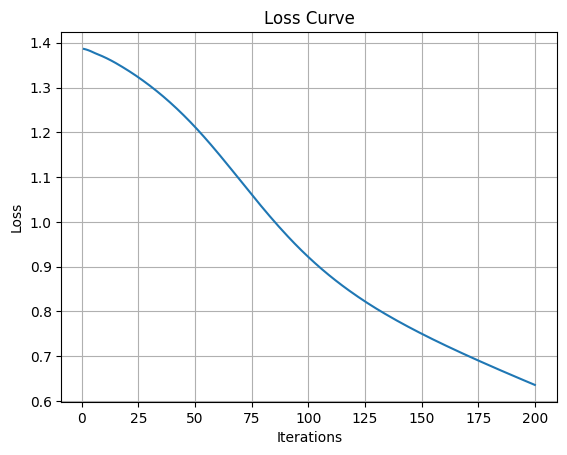

Training set score: 0.806818
Test set score: 0.842105


[[9 0 1 0]
 [0 9 0 0]
 [2 1 7 0]
 [2 0 0 7]]


              precision    recall  f1-score   support

          13       0.69      0.90      0.78        10
          16       0.90      1.00      0.95         9
           5       0.88      0.70      0.78        10
           8       1.00      0.78      0.88         9

    accuracy                           0.84        38
   macro avg       0.87      0.84      0.85        38
weighted avg       0.86      0.84      0.84        38



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(256,),
    max_iter=200,
    alpha=1e-4,
    solver="sgd",
    verbose=10,
    learning_rate_init=0.02,
)

mlp.fit(X_train, y_train)
loss_values = mlp.loss_curve_
iterations = np.arange(1, len(loss_values) + 1)

plt.plot(iterations, loss_values)
plt.title('Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


y_pred = mlp.predict(X_test)
print("Training set score: %f" % mlp.score(X_train, y_train))
print("Test set score: %f" % mlp.score(X_test, y_test))
print('\n')
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

